# Predicting Live Win Probabilities
### By Andrew Ebenbach

# Overview:
Oddsmakers are great at predicting the probability of a horse winning a race before it starts. However, new information collected during the race can be used to update these prior predictions before the race ends. As spectators, we naturally update our beliefs as to what horse is going to win as we watch the race progress. This notebook examines how prior predictions by the oddsmaker can be updated using machine learning techniques. 

Similar models, like the ones developed by Yahoo Sports, have become popular for other major sports such as football, basketball, and baseball. Fans like the ability to trace how the win probability of a team changes over the course of a game. Games in which the win probability of a team wildly fluctuates will often circulate on social media becasue they are seen as particularly exciting. Horse racing could benefit from the same engagement with similair techniques. 

# The Data:

All information used by the model was derived from the horse-tracking data or the prior probability given by the oddsmaker. However, the tracking data had to be significantly processed to extract the information which was needed. A single instance of tracking data does contain predictive information on its own because it does not contain any information about the horse's speed or any information about the rest of the pack. 

### Notes about the processed data:

1. The *positions* (1st, 2nd, 3rd...) of the horses at any point during the race is determined by the angular distance that each horse has traveled (the horse that traveled the most distance is the leader). *Angular distance* is determined by the total number of radians each horse has traveled around a point inside of the track. (this method does not always determine the order of the horses perfectly in close races)

2. Because latitude and longitude cannot be used as comparable units of distance, these units were converted onto a grid with axes in feet. (You may want to check out my [notebook](https://www.kaggle.com/code/andrewebenbach/making-latitude-and-longitude-usable-for-distances) on this subject matter). The *speed* of the horse is calculated by the straight-line distance traveled by the horse between the current trakus index and the fourth index back. Therefore, measurements of speed are in units roughly equal to feet per second.

3. Races are determined to be over when at least one horse has traveled a total straight line distance greater or equal to the stated race distance.

4. *Speed to cover* is the required difference above the leader's speed that the horse behind's true speed must be in order for the horse behind to make up the straight line distance between the two horses before the race is over. 

5. Three different train/test datasets are produced and used for three different models. Each dataset examines a different horse as the "leader" at the same points in time. The first dataset examines the horse in first place as the leader, the second dataset examines the horse in second as the leader, and the third dataset examines the horse in third as the leader. The motivation for this is so that the win probability for the top 3 horses can be predicted at any point during the race with 3 separate models. Of course, this logic could be extended to more horses than the top 3. 

6. The second and third *training* sets only include data in which horse(s) in front of the "leader" did not end up winning the race, for reasons that should become clear in the **Model** section.

### Explanation of each column in the engineered training data:

**avgSpeedToCover**: The average speed to cover of all the horses behind the leading horse.

**minSpeedToCover**: The minimum speed to cover of a horse behind the leading horse.

**leaderFinishDistance**: The distance in feet that the leader has left before finishing the race.

**avgLeaderDistance**: The average difference between the leader's total straight line distance and the behind horses' total straight line distance.

**minLeaderDistance**: The minimum difference between the leader's total straight line distance and a behind horse's total straight line distance.

**minLeaderDistanceEuc**: The minimum euclidian distance between the leader and a behind horse.

**priorWinProb**: The leader's prior odds (determined by the oddsmaker) converted to probabilities.

**proportionWinProb**: The proportion of the leader's prior probability to the sum of all the behind horses' prior probabilities (included because the odds do not usually add up to one).

**leaderSpeed**: The speed of the leader.

**maxSpeed**: The maximum speed among any of the horses behind the leader.

In [1]:

import pandas as pd
import numpy as np
import xgboost

import warnings
warnings.simplefilter("ignore")

#data where lead horse is examined
path_to_file = "../input/engineereddataforbigdataderby/test_data_V6.csv"
test_0 = pd.read_csv(path_to_file, index_col=(0))

path_to_file = "../input/engineereddataforbigdataderby/train_data_V6.csv"
train_0 = pd.read_csv(path_to_file, index_col=(0))

#second horse is examined
path_to_file = "../input/engineereddataforbigdataderby/test_reduced_1_V6.csv"
test_1 = pd.read_csv(path_to_file, index_col=(0))

path_to_file = "../input/engineereddataforbigdataderby/train_reduced_1_V6.csv"
train_1 = pd.read_csv(path_to_file, index_col=(0))

#third horse is examined
path_to_file = "../input/engineereddataforbigdataderby/test_reduced_2_V6.csv"
test_2 = pd.read_csv(path_to_file, index_col=(0))

path_to_file = "../input/engineereddataforbigdataderby/train_reduced_2_V6.csv"
train_2 = pd.read_csv(path_to_file, index_col=(0))

np.random.seed(123)


#retrieves x values, y values, and the baselines from train datasets
def get_train(train, drop_cols = []):

    train_x = (train.drop(["trakus_index","race_index","leadHorse"]+drop_cols,1))
    train_y = train_x.pop("frontWins")
    baseline_train = train_x.proportionWinProb

    return train_x, train_y, baseline_train

#normalizes an arbitrary number of training sets to according to one dataset's mean and stdev
def normalize_train_val(train_x,  others = []):
    train_means = train_x.mean()
    train_stds = train_x.std()

    train_x = (train_x - train_means) / train_stds
    
    for i in range(len(others)):
        others[i] = (others[i]- train_means) / train_stds
        
    return (train_x, *others)

#columns that were detrimental or did not conatin useful information during validation
drop_cols_test = ["avgSpeed", "leaderPathEfficiency", "numHorses", "avgLeaderDistanceEuc"]

#separate out the training sets 
trainX   , trainY   , baseline_train   = get_train(train_0, drop_cols_test)
trainX_1 , trainY_1 , baseline_train_1 = get_train(train_1 , drop_cols_test)
trainX_2,  trainY_2 , baseline_train_2 = get_train(train_2, drop_cols_test)

#create dfs for testing
testX   = test_0.copy().drop(drop_cols_test+["trakus_index","race_index","leadHorse"],1)
testX_1 = test_1.copy().drop(drop_cols_test+["trakus_index","race_index","leadHorse"],1)
testX_2 = test_2.copy().drop(drop_cols_test+["trakus_index","race_index","leadHorse"],1)

testY   = testX.pop("frontWins")
testY_1 = testX_1.pop("frontWins")
testY_2 = testX_2.pop("frontWins")

#normalize all data sets according to the lead horse training set
trainX, testX, trainX_1, testX_1, trainX_2, testX_2 = normalize_train_val(trainX, [testX, trainX_1, testX_1, trainX_2, testX_2])

# The Model:

Three separate XGBoost models are trained on the three different levels of the training data. XGBoost, a gradient boosting model, was found to have similar results to a neural network trained on the same data during validation, but XGBoost was chosen because it has the added advantage of explainability through use of SHAP values.

The first model is simply fitted to the training data from the first dataset. Therefore, the first model will predict the probability of the current leader winning the race.

The second model is fitted to the second data set, which only contains instances where the horse in first place did not win. Therefore, this model will predict the probability that the horse in second place will win *given* that the horse in first place does not win. Because the probability that the first place horse wins is known from the first model, the unconditional probability that the second place horse wins can be calculated from the second model's output:

P(horse 2 wins) = P(horse 2 wins | horse 1 loses) * (1- P(horse 1 wins))

The third model is fitted to the third dataset, which only contains instances where the horse in first or second place did not win. Therefore, this model will predict the probability that the horse in third will win *given* that the horses in first and second place do not win. Because the probability that the first or second place horse wins is known from the other model's predictions, the unconditional probability that the third place horse wins can be calculated from the third model's output:

P(horse 3 wins) = P(horse 3 wins | horse 1 & horse 2 loses) * (1- P(horse 1 wins) - P(horse 2 wins))

In [2]:
from xgboost import XGBClassifier

def createModelXGB():
    #these parameters were found to be optimal in validation
    xgb_model = XGBClassifier(learning_rate=0.01, 
                      max_depth=3,
                      min_child_weight=0, 
                      n_estimators=1000, 
                      objective='binary:logistic', 
                      reg_alpha=0, 
                      reg_lambda=0,
                      subsample = .33,
                      colsample_bylevel=1,
                      n_jobs=4,
                      eval_metric = "auc",
                      seed=10003)
    return xgb_model

#create a separate model for each level of prediction (first, second, and third)
xgb_model_0 = createModelXGB()
xgb_model_1 = createModelXGB()
xgb_model_2 = createModelXGB()

#fit each model to their according dataset
xgb_model_0.fit(trainX, trainY)
xgb_model_1.fit(trainX_1, trainY_1)
xgb_model_2.fit(trainX_2, trainY_2)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=0,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=10003, reg_alpha=0, reg_lambda=0, ...)

# Evaluation:

The model is evaluated by the area under the ROC curve that its predictions produce, and then compared to the oddsmaker's prior predictions as a baseline.

The results show that the model beats the baseline overall with an ROC AUC of about .79 where the baseline gets results of about .72. However, these results differ at each level. The model is best at determining the probability of the first-place horse winning, but its much closer to the baseline when predicting the probability that second or third wins.

In [3]:
#predict each model on their according dataset
pred_0 = xgb_model_0.predict_proba(testX)[:,1]
pred_1 = xgb_model_1.predict_proba(testX_1)[:,1]
pred_2 = xgb_model_2.predict_proba(testX_2)[:,1]

#columns needed for eval
keep_cols = ["frontWins", "trakus_index", "priorWinProb", "race_index", "leadHorse"]

#the data will be combined later into separate columns in a dataframe, so need to rename columns
test_0 = test_0.loc[:,keep_cols].rename(columns={"frontWins": "wins0", "priorWinProb": "prior0", "leadHorse": "horse0"})
test_1 = test_1.loc[:,keep_cols].rename(columns={"frontWins": "wins1", "priorWinProb": "prior1", "leadHorse": "horse1"})
test_2 = test_2.loc[:,keep_cols].rename(columns={"frontWins": "wins2", "priorWinProb": "prior2", "leadHorse": "horse2"})

test_0["pred_0"] = pred_0
test_1["pred_1"] = pred_1
test_2["pred_2"] = pred_2

#merge the data needed for evaluation
test_all = test_0.merge(test_1, on = ["trakus_index","race_index"], how = "inner")
test_all = test_all.merge(test_2, on = ["trakus_index","race_index"], how = "inner")

#calculate the actual predicted probabilities of second and third winning
test_all["pred_1"] = test_all.pred_1 * (1- test_all.pred_0)
test_all["pred_2"] = test_all.pred_2 * (1- test_all.pred_0 - test_all.pred_1)

from sklearn.metrics import roc_auc_score, roc_curve

#combine all the evaluation data for an overall result
y_all = pd.concat([test_all.wins0, test_all.wins1, test_all.wins2])
pred_all = pd.concat([test_all.pred_0, test_all.pred_1, test_all.pred_2])
baseline_all = pd.concat([test_all.prior0, test_all.prior1, test_all.prior2])

#calculate overall accuracy of model
results = roc_auc_score(y_all, pred_all)
baseline_results = roc_auc_score(y_all,baseline_all)

#also interested in accuracy at each level
print("Lead Horse-\n", "model ROC AUC:",roc_auc_score(test_all.wins0, test_all.pred_0) )
print(" baseline ROC:",roc_auc_score(test_all.wins0, test_all.prior0), "\n" )

print("Second Horse-\n", "model ROC AUC:",roc_auc_score(test_all.wins1, test_all.pred_1) )
print(" baseline ROC:",roc_auc_score(test_all.wins1, test_all.prior1), "\n" )

print("Third Horse-\n", "model ROC AUC:",roc_auc_score(test_all.wins2, test_all.pred_2) )
print(" baseline ROC:",roc_auc_score(test_all.wins2, test_all.prior2), "\n" )



print("Overall-\n", "model ensemble ROC AUC:",results)
print(" baseline ROC:",baseline_results)

Lead Horse-
 model ROC AUC: 0.8090365557642055
 baseline ROC: 0.7151931546446192 

Second Horse-
 model ROC AUC: 0.7626295304604863
 baseline ROC: 0.7211173893199248 

Third Horse-
 model ROC AUC: 0.7695433991050994
 baseline ROC: 0.7314703584773162 

Overall-
 model ensemble ROC AUC: 0.7921895996702395
 baseline ROC: 0.7237283684509492


# Examining Feature Importance:

SHAP values are fitted to the first level model. The prior win probability given by the odds maker is by far the most important feature to the model's output. Therefore, the model's prediction should be seen as an update to a prior prediction based on new information.

The leader's finish distance does not appear to be particularly important in terms of absolute SHAP values, but it has an important interaction effect with the other features; shown below by its interaction with prior win probability. The effect makes sense inuitively: at the beggining of the race, the model-predicted probability lies near the oddsmaker's pre-race prediction, and near the end of the race, the oddsmaker's prediction becomes less important than the information on the track.

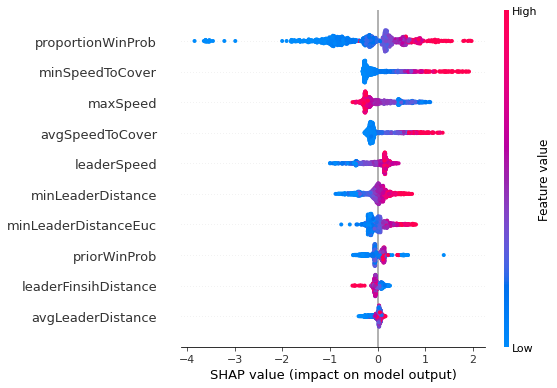

In [4]:
#examine feature importance with shap
import shap

data_for_prediction = testX.sample(1000)

explainer = shap.TreeExplainer(xgb_model_0)

shap_values = explainer.shap_values(data_for_prediction)

shap.summary_plot(shap_values, data_for_prediction)

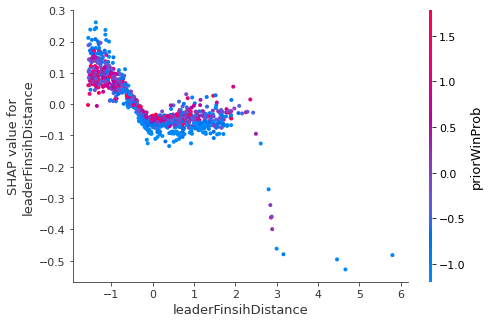

In [5]:
#interesting relationship between leaderFinsihDistance and priorWinProb
shap.dependence_plot('leaderFinsihDistance', shap_values, data_for_prediction, interaction_index="priorWinProb")

# Visualizing the live win probabilities of a race:

The following chart shows the outputs of the model over the course of the 2019 Jockey Club Oaks Invitational Stakes, which was in the test set. The model shows a close race up until the very end when Edisa (horse 1) starts gaining speed and takes the lead. 

*Note that the model can only predict probabilities for horses that are in the top 3. So, only three horses will have a prediction for any given trakus index.*

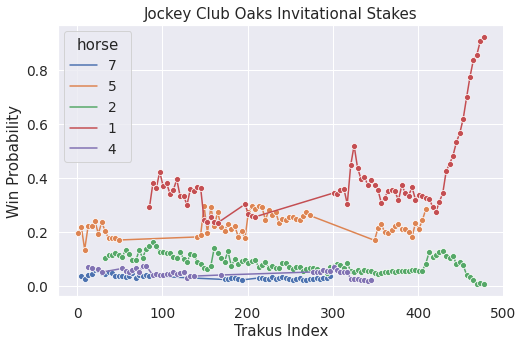

In [6]:
import seaborn as sns

#function to view win probabilities of each horse over the course of the race
def view_race(df, race_no, place):
    race = df.loc[df.race_index == race_no]
    y = "pred_" + str(place)
    hue = "horse" + str(place)
    
    #combine data at each level into into a longer dataframe so each horse's win probability is
    #shown as long as that horse is in the top 3
    trakus_concat = pd.concat([race.trakus_index,race.trakus_index,race.trakus_index]).rename("trakus_index")
    trakus_concat.index = range(len(trakus_concat))
    
    horse_concat = pd.concat([race.horse0, race.horse1, race.horse2]).rename("horse")
    horse_concat.index = range(len(trakus_concat))
    
    pred_concat = pd.concat([race.pred_0, race.pred_1, race.pred_2]).rename("pred")
    pred_concat.index = range(len(trakus_concat))
    
    display = pd.DataFrame({trakus_concat.name : trakus_concat, horse_concat.name: horse_concat, pred_concat.name:pred_concat})
    
    #drop horses that are only briefly in the top 3
    low_count = horse_concat.value_counts() <= 15
    
    for x in horse_concat.unique():
        if(low_count.loc[x]):
            display = display.loc[display.horse != x]

    
    sns.set(rc={'figure.figsize':(8,5)}, font_scale=1.25)
    sns.lineplot(data=display, x= "trakus_index" , y = "pred", hue= "horse", marker="o").set(title="Jockey Club Oaks Invitational Stakes",
                                                                                            xlabel="Trakus Index",
                                                                                            ylabel= "Win Probability")

#race 1289 is the Jockey Club Oaks Invitational Stakes
race_no = 1289
view_race(test_all, race_no, 0)

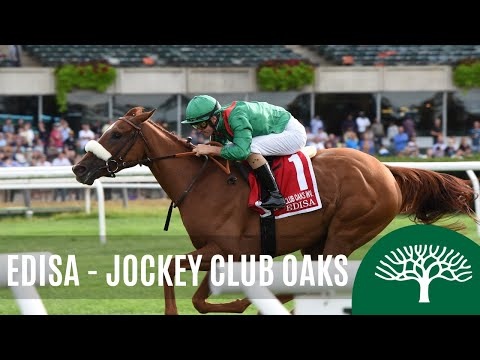

In [7]:
#link to video of race for ease of comparison to probabilities
from IPython.display import YouTubeVideo
YouTubeVideo('zCHfEBgwudw', width=640, height=400)

Thanks for reading!

# Links:

**Kaggle**:

[Converting Latitude/Longitude to distance](https://www.kaggle.com/code/andrewebenbach/making-latitude-and-longitude-usable-for-distances)

**Github**:

[Data Engineering 1](https://github.com/aebenbach/Derby/blob/79a0eb7215254f51f85a8bcf38d7035551ee5c8b/DataEngineering1.py)

[Data Engineering 2](https://github.com/aebenbach/Derby/blob/79a0eb7215254f51f85a8bcf38d7035551ee5c8b/DataEngineering2.py)